<a href="https://colab.research.google.com/github/krishalvian/Pancreatic-Mass-Segmentation/blob/main/Skenario_2_Mask_R_CNN_Simplify_Fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Segmentasi Tumor Pankreas Berbasis Citra Hasil Endoscopic Ultrasound (EUS) Menggunakan Metode Mask Region-Convolutional Neural Network**

Menghubungkan Google Colab dengan Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Mengimpor Library dan Module yang diperlukan untuk penelitian

In [2]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import seaborn as sns

Memuat path untuk citra dan mask pada dataset training, validasi, dan testing menggunakan glob dan sorted untuk memastikan file terbaca dengan urutan yang konsisten.

In [3]:
train_images = sorted(glob.glob("/content/drive/MyDrive/Final/Split/Images/Train/*.jpg"))
train_masks  = sorted(glob.glob("/content/drive/MyDrive/Final/Split/Labels/Train/*.jpg"))
val_images   = sorted(glob.glob("/content/drive/MyDrive/Final/Split/Images/Val/*.jpg"))
val_masks    = sorted(glob.glob("/content/drive/MyDrive/Final/Split/Labels/Val/*.jpg"))
test_images  = sorted(glob.glob("/content/drive/MyDrive/Final/Split/Images/Test/*.jpg"))
test_masks   = sorted(glob.glob("/content/drive/MyDrive/Final/Split/Labels/Test/*.jpg"))

print("Jumlah data training:", len(train_images))
print("Jumlah data testing:", len(test_images))
print("Jumlah data validasi:", len(val_images))

Jumlah data training: 1183
Jumlah data testing: 338
Jumlah data validasi: 169


Dari setiap path tersebut, terlihat bahwa untuk jumlah data training sebanyak 1183 citra, data testing sebanyak 338 citra, dan data validasi sebanyak 169 citra

Selanjutnya, membuat model Mask R-CNN yang digunakan untuk penelitian

In [4]:
class TumorSegmentationGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=4, target_size=(512, 512), shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        masks = []

        for idx in indexes:
            image = cv2.imread(self.image_paths[idx])
            image = cv2.resize(image, self.target_size)
            image = image.astype(np.float32) / 255.0

            mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.target_size)
            mask = (mask > 127).astype(np.float32)
            mask = np.expand_dims(mask, axis=-1)

            images.append(image)
            masks.append(mask)

        return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

In [5]:
def build_segmentation_model(input_shape=(512, 512, 3)):
    inputs = layers.Input(shape=input_shape)

    # Downsampling (encoder)
    x = layers.Conv2D(32, 5, activation='elu', padding='same')(inputs)  # Ukuran kernel 5x5, ELU activation
    x = layers.MaxPooling2D()(x)  # 256x256
    x = layers.Conv2D(64, 5, activation='elu', padding='same')(x)
    x = layers.MaxPooling2D()(x)  # 128x128
    x = layers.Conv2D(128, 5, activation='elu', padding='same')(x)
    x = layers.MaxPooling2D()(x)  # 64x64

    # Bottleneck
    x = layers.Conv2D(256, 5, activation='elu', padding='same')(x)  # Ukuran kernel 5x5, ELU activation

    # Upsampling (decoder) - jangan over!
    x = layers.Conv2DTranspose(128, 5, strides=2, padding='same')(x)  # 128x128
    x = layers.Conv2DTranspose(64, 5, strides=2, padding='same')(x)   # 256x256
    x = layers.Conv2DTranspose(32, 5, strides=2, padding='same')(x)   # 512x512

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)

    return models.Model(inputs, outputs)

In [6]:
def conv_block(x, filters, kernel_size=5):  # Ukuran kernel 5x5
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ELU()(x)  # Aktivasi ELU
    return x

def build_mask_rcnn(input_shape=(512, 512, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # Backbone: ResNet50 pretrained
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    C3 = base_model.get_layer("conv3_block4_out").output  # 64x64
    C4 = base_model.get_layer("conv4_block6_out").output  # 32x32
    C5 = base_model.get_layer("conv5_block3_out").output  # 16x16

    # Feature Pyramid Network (FPN)
    P5 = conv_block(C5, 256)                             # 16x16
    P4 = layers.Add()([conv_block(C4, 256), layers.UpSampling2D()(P5)])  # 32x32
    P3 = layers.Add()([conv_block(C3, 256), layers.UpSampling2D()(P4)])  # 64x64

    # Dummy RPN + ROI Pooling (simplified)
    roi_pooled = layers.GlobalAveragePooling2D()(P3)
    bbox_output = layers.Dense(4, name='bbox_deltas')(roi_pooled)

    # Mask branch decoder - target output 512x512
    x = conv_block(P3, 256)                    # 64x64
    x = layers.UpSampling2D(size=(2,2))(x)     # 128x128
    x = conv_block(x, 128)
    x = layers.UpSampling2D(size=(2,2))(x)     # 256x256
    x = conv_block(x, 64)
    x = layers.UpSampling2D(size=(2,2))(x)     # 512x512
    x = conv_block(x, 32)

    mask_output = layers.Conv2D(num_classes, (1,1), activation='sigmoid', name='mask_output')(x)

    # Final model
    return models.Model(inputs, outputs=mask_output)

In [7]:
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

model = build_mask_rcnn()

model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [8]:
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

In [9]:
train_gen = TumorSegmentationGenerator(train_images, train_masks, batch_size=4)
val_gen = TumorSegmentationGenerator(val_images, val_masks, batch_size=4)

Melakukan training pada model yang telah dirancang sedemikian hingga dengan melakukan iterasi sebanyak 25 epoch agar menghasilkan model yang terbaik

In [10]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[checkpoint, reduce_lr, early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8482 - loss: 0.4835

295/295 ━━━━━━━━━━━━━━━━━━━━ 1235s 4s/step - accuracy: 0.8483 - loss: 0.4834 - val_accuracy: 0.8828 - val_loss: 0.9994 - learning_rate: 0.0010
Epoch 2/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.9144 - loss: 0.3636

295/295 ━━━━━━━━━━━━━━━━━━━━ 211s 716ms/step - accuracy: 0.9144 - loss: 0.3636 - val_accuracy: 0.8829 - val_loss: 0.9950 - learning_rate: 0.0010
Epoch 3/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 203s 689ms/step - accuracy: 0.9243 - loss: 0.3247 - val_accuracy: 0.8834 - val_loss: 0.9967 - learning_rate: 0.0010
Epoch 4/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.9253 - loss: 0.3249

295/295 ━━━━━━━━━━━━━━━━━━━━ 208s 706ms/step - accuracy: 0.9253 - loss: 0.3249 - val_accuracy: 0.8760 - val_loss: 0.4357 - learning_rate: 0.0010
Epoch 5/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 260s 698ms/step - accuracy: 0.9320 - loss: 0.2943 - val_accuracy: 0.9102 - val_loss: 0.5556 - learning_rate: 0.0010
Epoch 6/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.9363 - loss: 0.2791

295/295 ━━━━━━━━━━━━━━━━━━━━ 207s 701ms/step - accuracy: 0.9363 - loss: 0.2791 - val_accuracy: 0.9222 - val_loss: 0.2933 - learning_rate: 0.0010
Epoch 7/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 203s 688ms/step - accuracy: 0.9447 - loss: 0.2422 - val_accuracy: 0.9133 - val_loss: 0.3557 - learning_rate: 0.0010
Epoch 8/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 204s 690ms/step - accuracy: 0.9517 - loss: 0.2178 - val_accuracy: 0.9127 - val_loss: 0.5593 - learning_rate: 0.0010
Epoch 9/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.9524 - loss: 0.2156
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
295/295 ━━━━━━━━━━━━━━━━━━━━ 204s 690ms/step - accuracy: 0.9524 - loss: 0.2155 - val_accuracy: 0.9218 - val_loss: 0.3184 - learning_rate: 0.0010
Epoch 10/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.9634 - loss: 0.1668

295/295 ━━━━━━━━━━━━━━━━━━━━ 213s 723ms/step - accuracy: 0.9635 - loss: 0.1668 - val_accuracy: 0.9512 - val_loss: 0.2434 - learning_rate: 5.0000e-04
Epoch 11/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.9724 - loss: 0.1251

295/295 ━━━━━━━━━━━━━━━━━━━━ 219s 742ms/step - accuracy: 0.9724 - loss: 0.1251 - val_accuracy: 0.9576 - val_loss: 0.1885 - learning_rate: 5.0000e-04
Epoch 12/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.9762 - loss: 0.1144

295/295 ━━━━━━━━━━━━━━━━━━━━ 213s 720ms/step - accuracy: 0.9762 - loss: 0.1144 - val_accuracy: 0.9684 - val_loss: 0.1490 - learning_rate: 5.0000e-04
Epoch 13/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.9796 - loss: 0.0965

295/295 ━━━━━━━━━━━━━━━━━━━━ 269s 745ms/step - accuracy: 0.9796 - loss: 0.0964 - val_accuracy: 0.9758 - val_loss: 0.1060 - learning_rate: 5.0000e-04
Epoch 14/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 205s 692ms/step - accuracy: 0.9821 - loss: 0.0834 - val_accuracy: 0.9766 - val_loss: 0.1083 - learning_rate: 5.0000e-04
Epoch 15/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 204s 692ms/step - accuracy: 0.9841 - loss: 0.0732 - val_accuracy: 0.9741 - val_loss: 0.1184 - learning_rate: 5.0000e-04
Epoch 16/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.9840 - loss: 0.0719
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
295/295 ━━━━━━━━━━━━━━━━━━━━ 204s 690ms/step - accuracy: 0.9840 - loss: 0.0719 - val_accuracy: 0.9690 - val_loss: 0.1387 - learning_rate: 5.0000e-04
Epoch 17/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.9856 - loss: 0.0681

295/295 ━━━━━━━━━━━━━━━━━━━━ 217s 736ms/step - accuracy: 0.9856 - loss: 0.0681 - val_accuracy: 0.9823 - val_loss: 0.0785 - learning_rate: 2.5000e-04
Epoch 18/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.9897 - loss: 0.0483

295/295 ━━━━━━━━━━━━━━━━━━━━ 213s 719ms/step - accuracy: 0.9897 - loss: 0.0483 - val_accuracy: 0.9836 - val_loss: 0.0730 - learning_rate: 2.5000e-04
Epoch 19/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.9908 - loss: 0.0438

295/295 ━━━━━━━━━━━━━━━━━━━━ 212s 719ms/step - accuracy: 0.9908 - loss: 0.0438 - val_accuracy: 0.9853 - val_loss: 0.0659 - learning_rate: 2.5000e-04
Epoch 20/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.9924 - loss: 0.0349

295/295 ━━━━━━━━━━━━━━━━━━━━ 220s 747ms/step - accuracy: 0.9924 - loss: 0.0349 - val_accuracy: 0.9870 - val_loss: 0.0598 - learning_rate: 2.5000e-04
Epoch 21/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 206s 697ms/step - accuracy: 0.9925 - loss: 0.0349 - val_accuracy: 0.9871 - val_loss: 0.0613 - learning_rate: 2.5000e-04
Epoch 22/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 205s 696ms/step - accuracy: 0.9931 - loss: 0.0328 - val_accuracy: 0.9868 - val_loss: 0.0629 - learning_rate: 2.5000e-04
Epoch 23/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.9932 - loss: 0.0318

295/295 ━━━━━━━━━━━━━━━━━━━━ 264s 703ms/step - accuracy: 0.9932 - loss: 0.0318 - val_accuracy: 0.9877 - val_loss: 0.0543 - learning_rate: 2.5000e-04
Epoch 24/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 204s 691ms/step - accuracy: 0.9942 - loss: 0.0271 - val_accuracy: 0.9872 - val_loss: 0.0568 - learning_rate: 2.5000e-04
Epoch 25/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 204s 690ms/step - accuracy: 0.9942 - loss: 0.0272 - val_accuracy: 0.9878 - val_loss: 0.0549 - learning_rate: 2.5000e-04


Melakukan visualisasi hasil dari training model yang telah dilakukan dengan menggunakan data testing

In [11]:
def visualize_predictions_triplet_colored(model, test_gen, num_images=10):
    for i in range(min(num_images, len(test_gen))):
        image_batch, mask_batch = test_gen[i]
        image = image_batch[0]  # (512, 512, 3)

        # Handle y_true bisa berupa dict atau array
        if isinstance(mask_batch, dict):
            true_mask = mask_batch["mask_output"][0, :, :, 0]
        elif isinstance(mask_batch, list):
            true_mask = mask_batch[0][..., 0]
        else:
            true_mask = mask_batch[0, :, :, 0]

        # Predict
        prediction = model.predict(np.expand_dims(image, axis=0), verbose=0)

        # Ambil mask_output dari hasil prediksi
        if isinstance(prediction, dict):
            pred_mask = prediction["mask_output"][0, :, :, 0]
        elif isinstance(prediction, list):
            pred_mask = prediction[0][0, :, :, 0]
        else:
            pred_mask = prediction[0, :, :, 0]

        pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

        # Overlay
        overlay = image.copy()
        overlay[pred_mask_bin == 1] = [255, 0, 0]

        # Plot 3 panel
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(image)
        axs[0].set_title("Raw Image")

        axs[1].imshow(true_mask, cmap='gray')
        axs[1].set_title("Ground Truth Mask")

        axs[2].imshow(overlay)
        axs[2].set_title("Predicted Mask (Overlay)")

        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

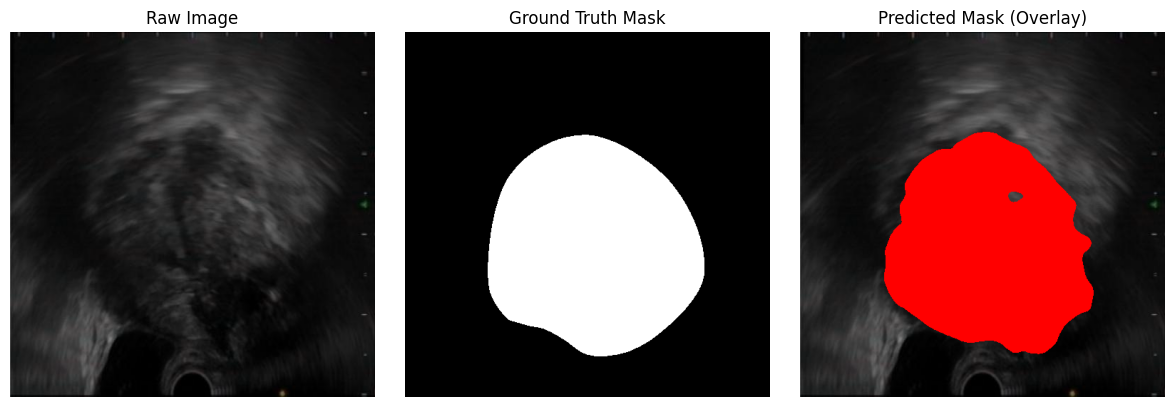

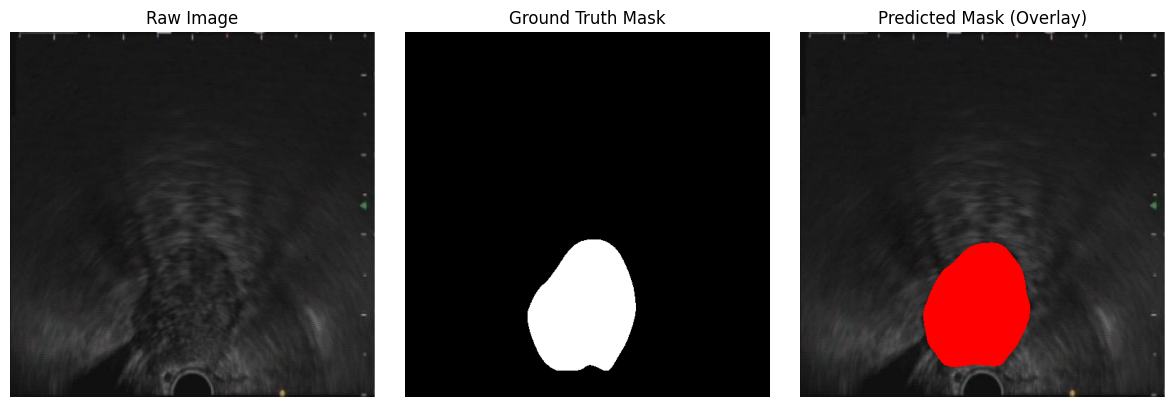

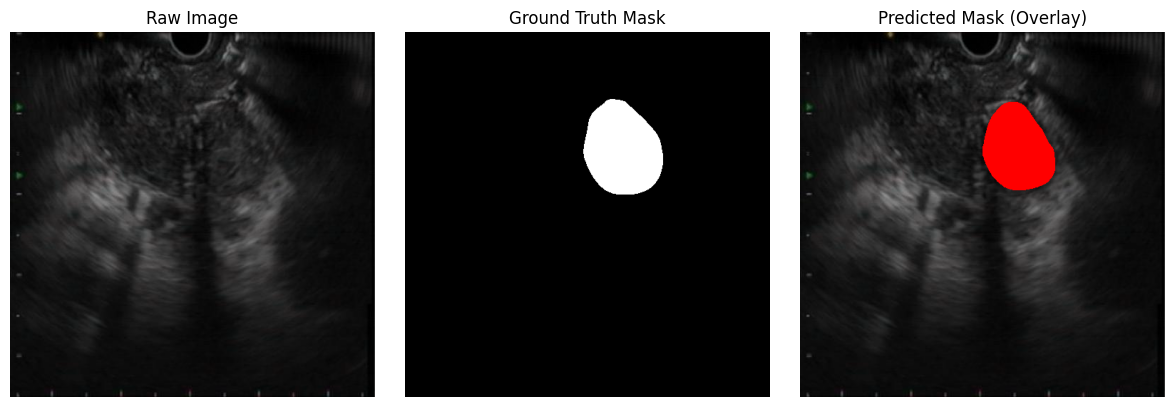

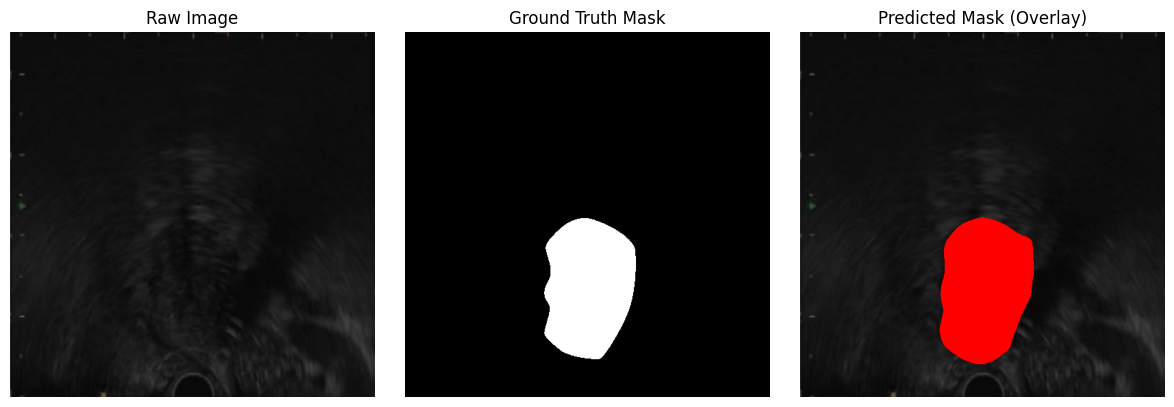

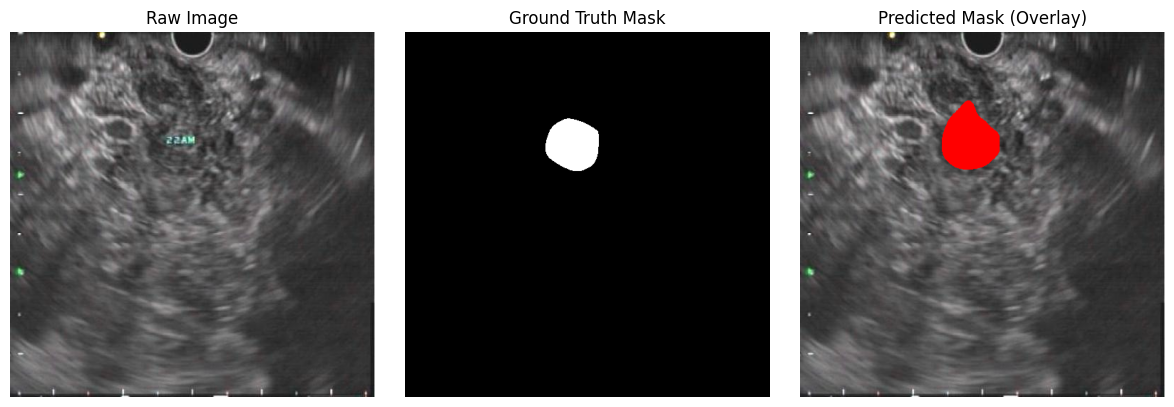

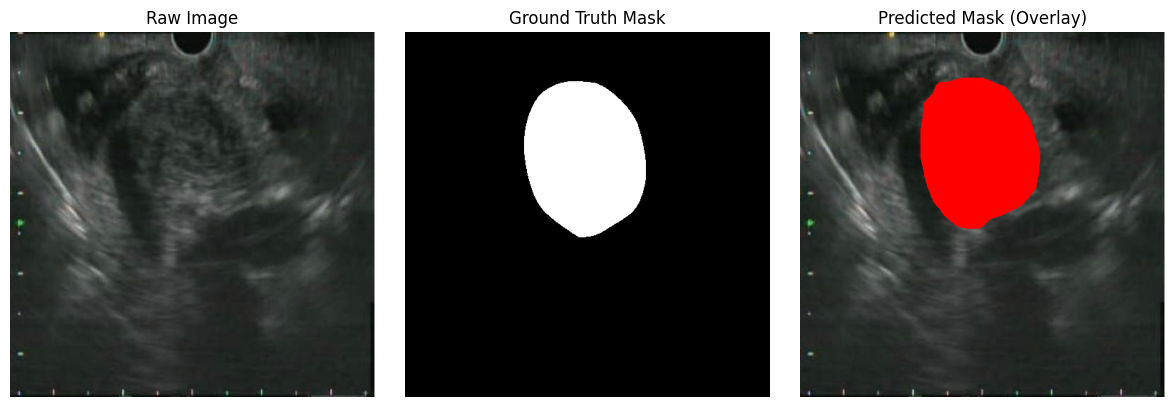

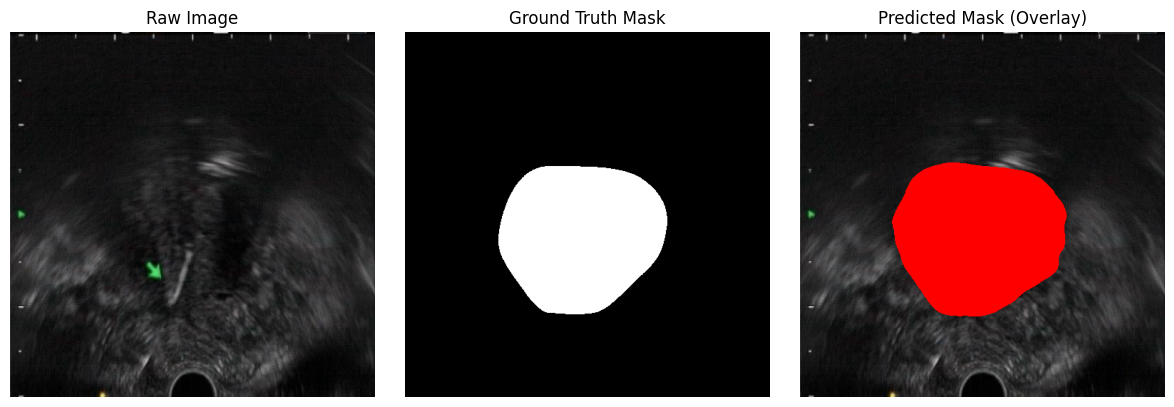

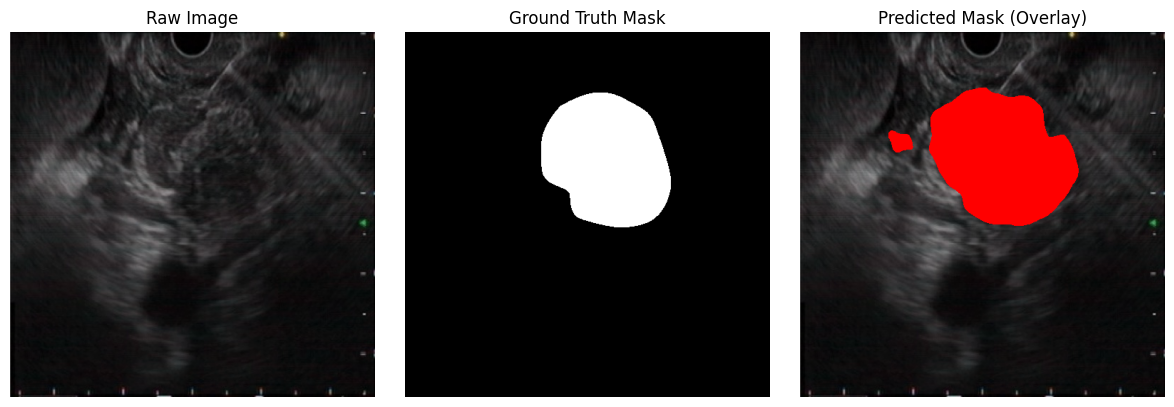

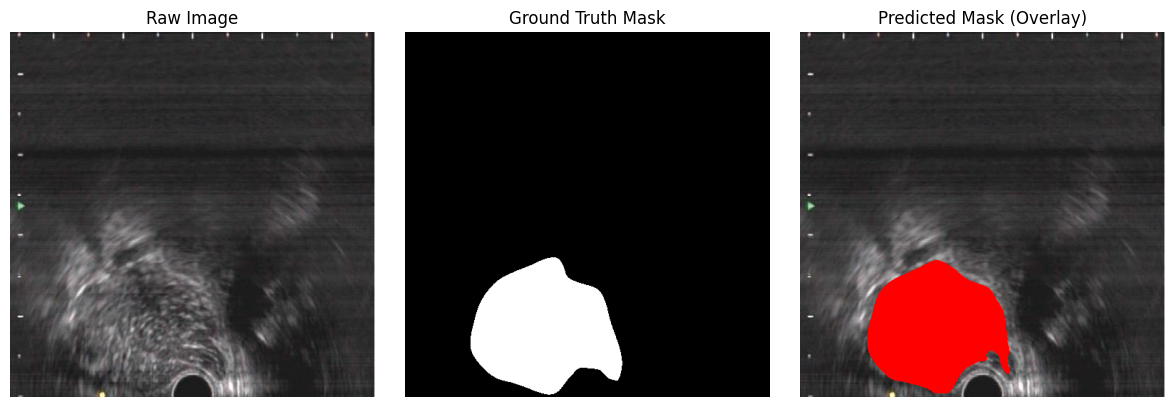

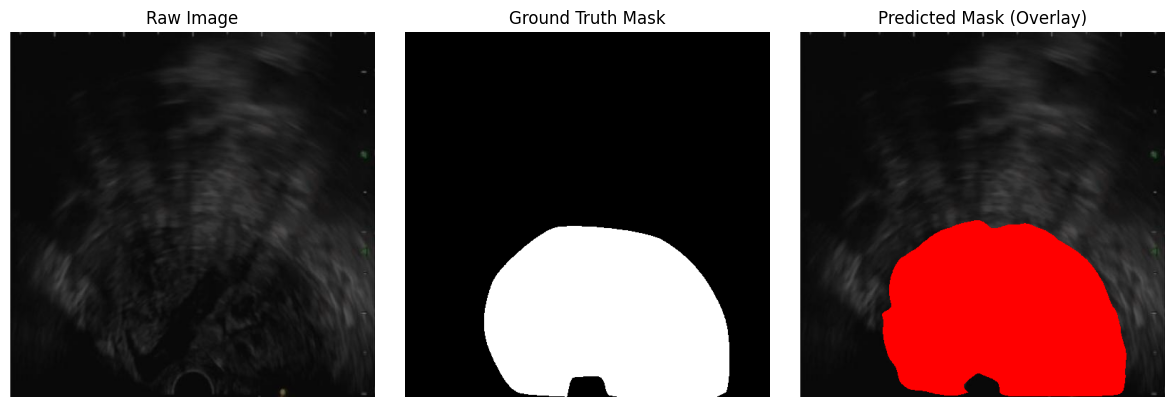

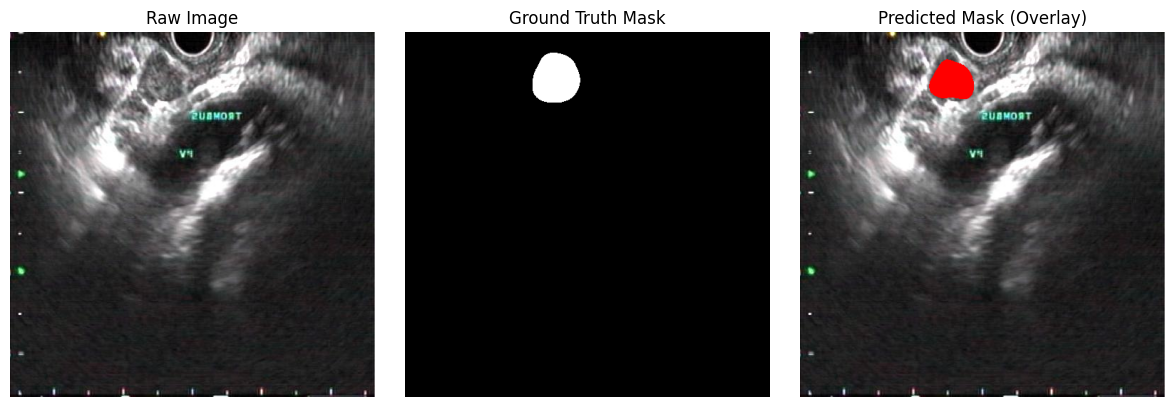

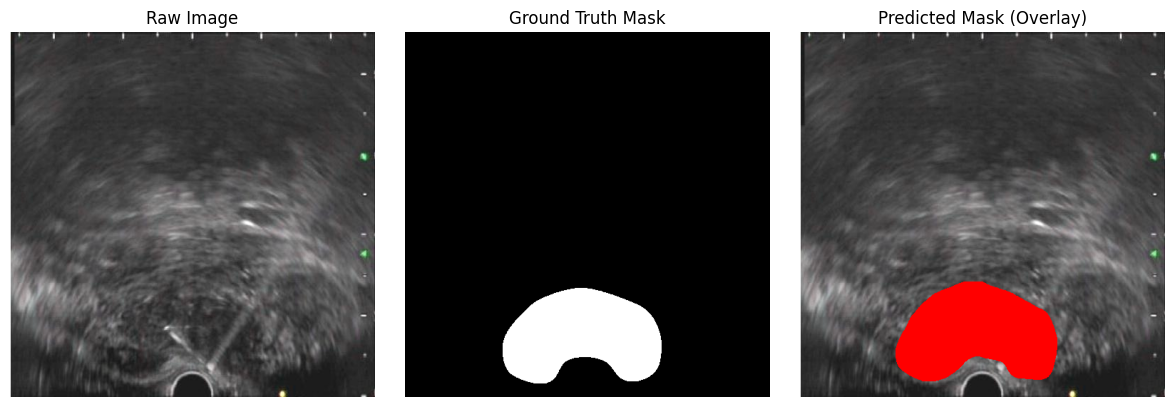

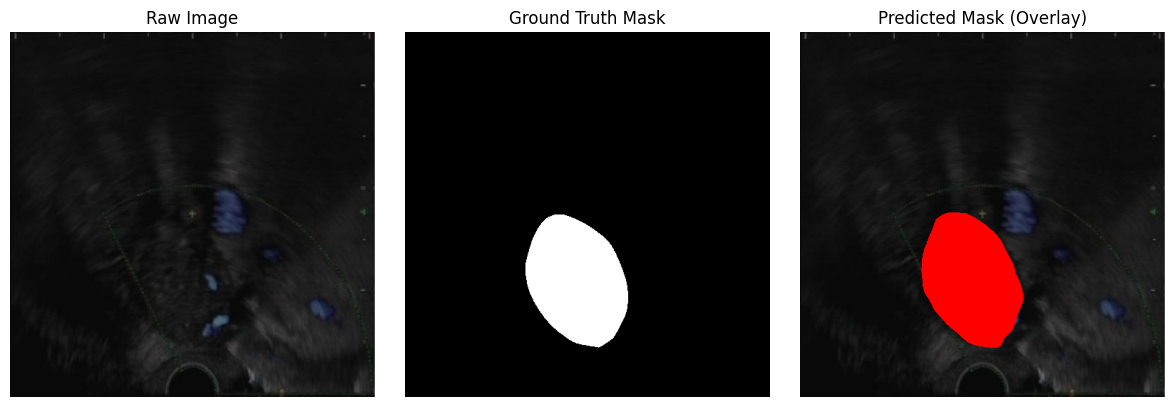

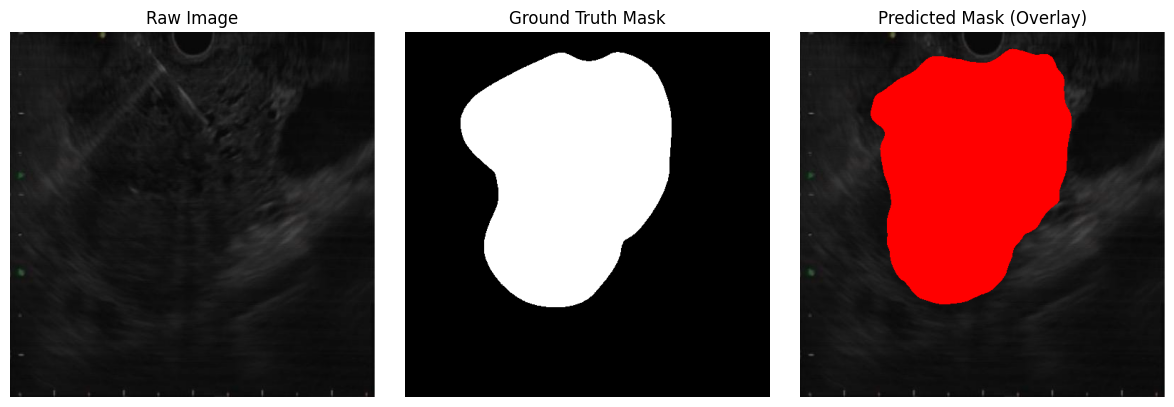

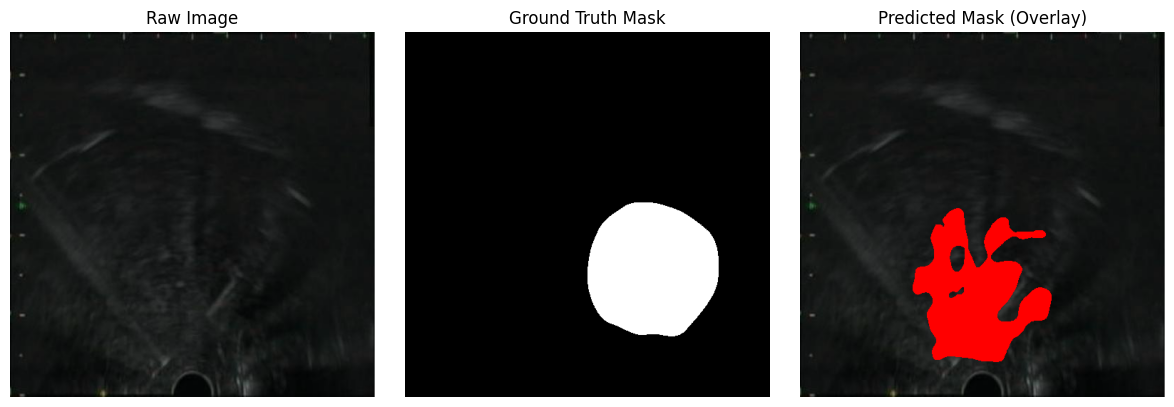

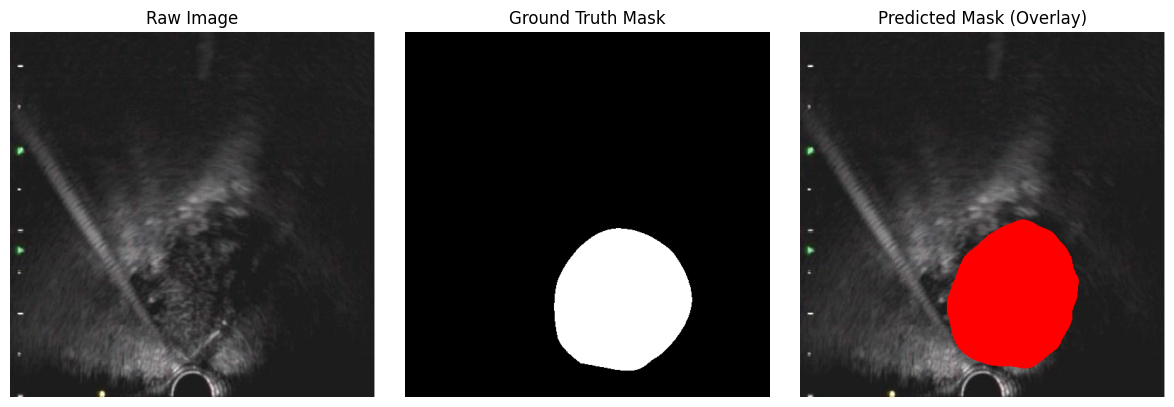

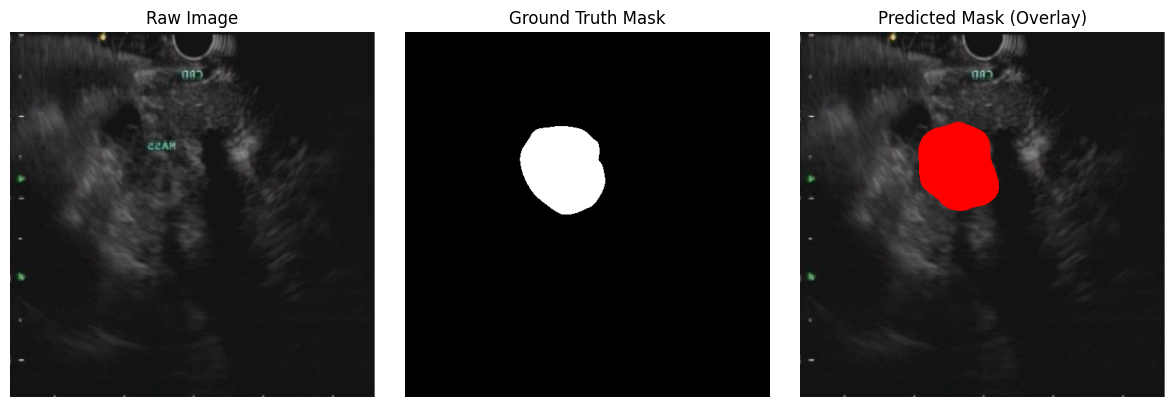

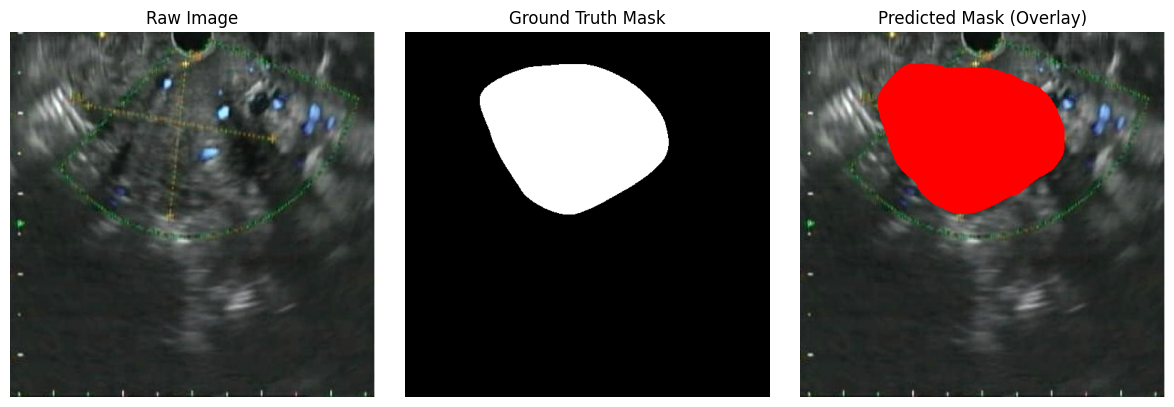

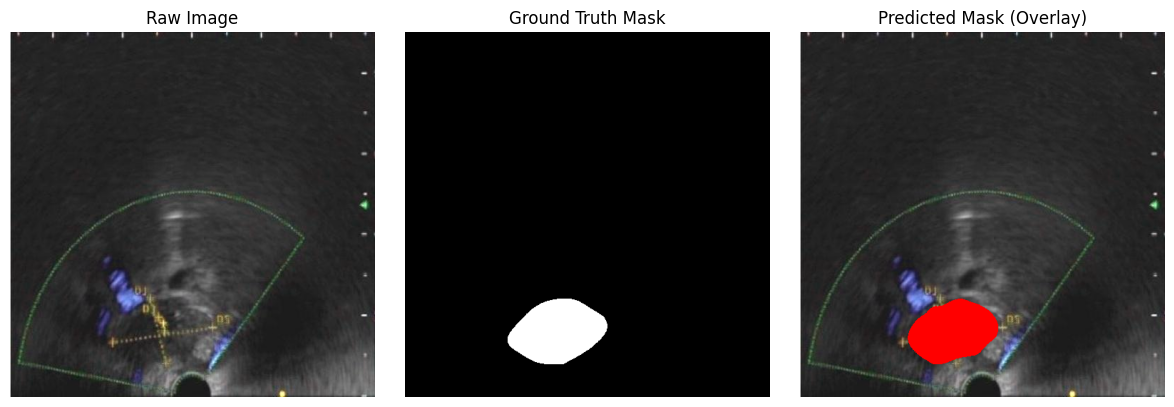

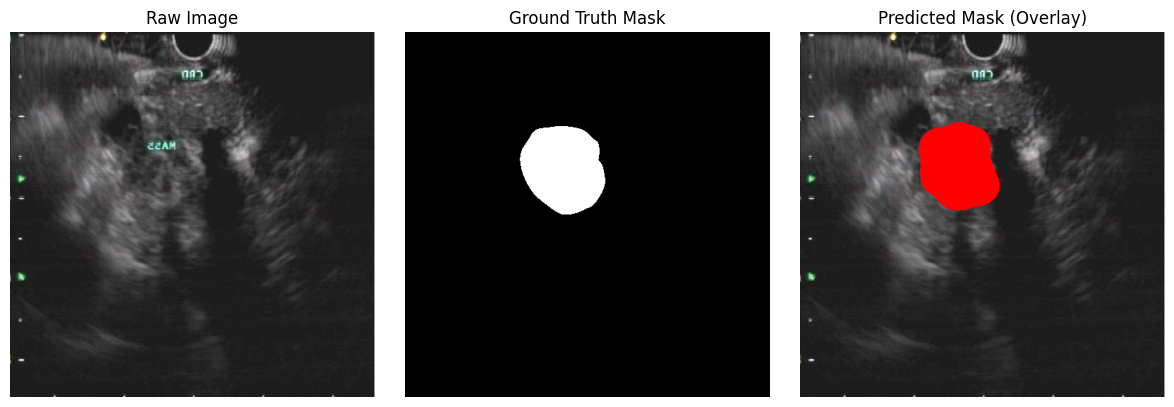

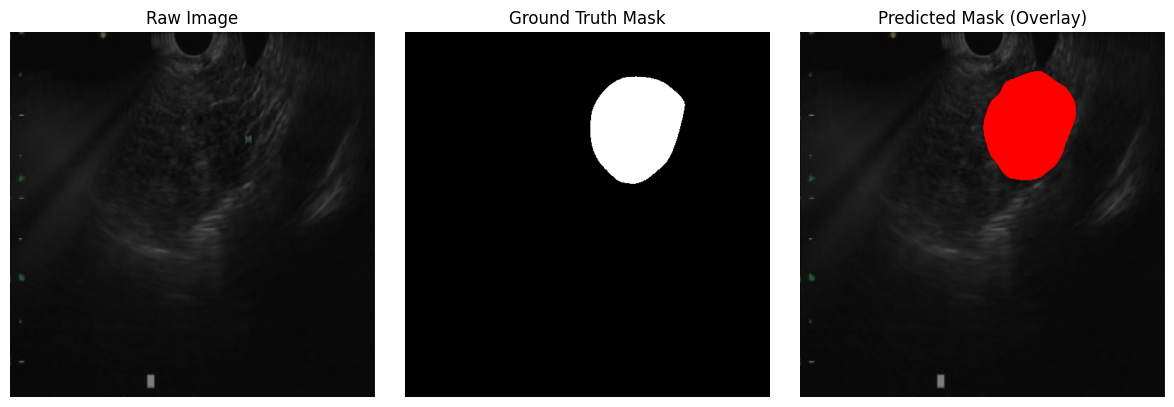

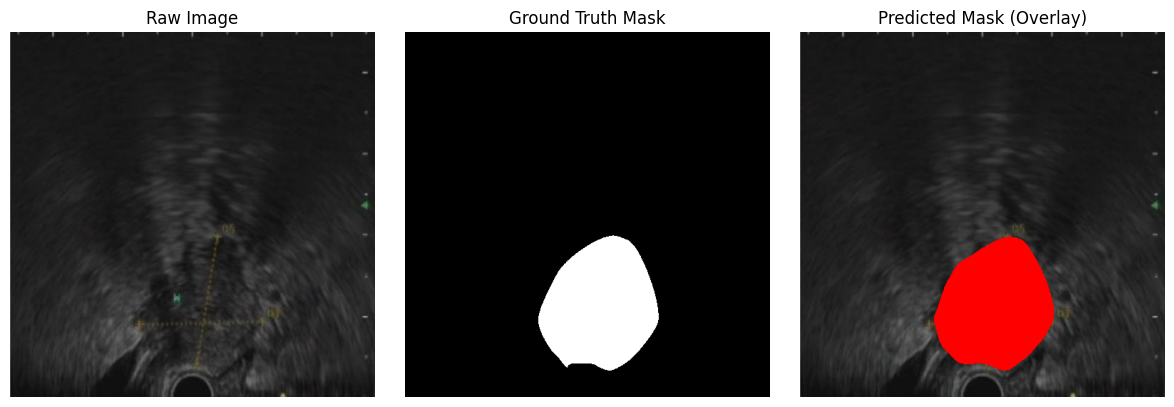

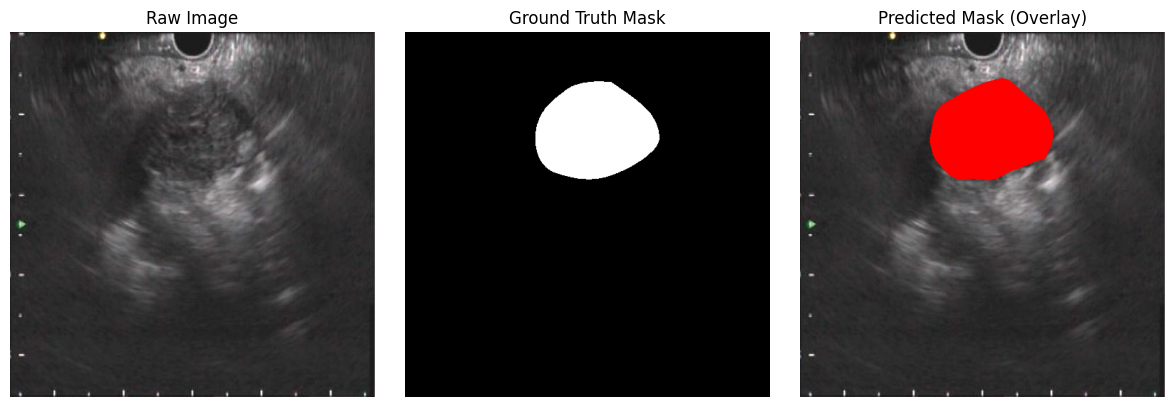

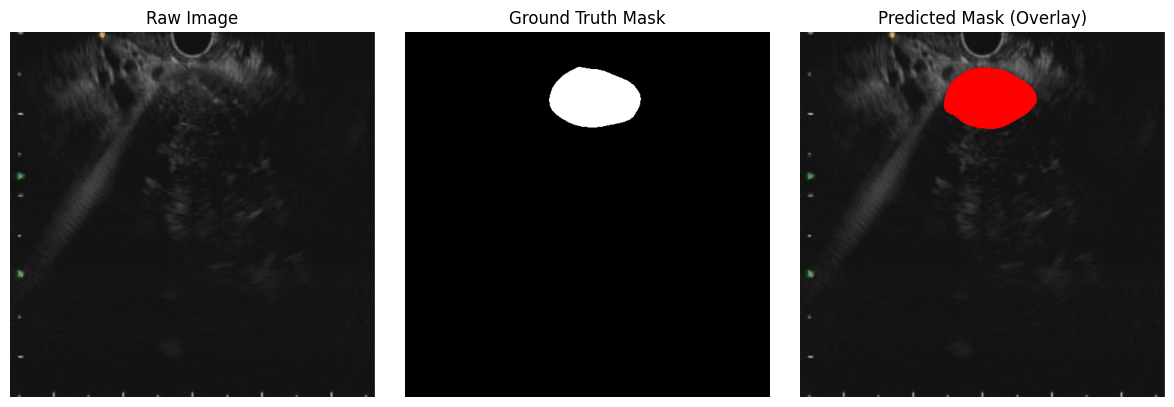

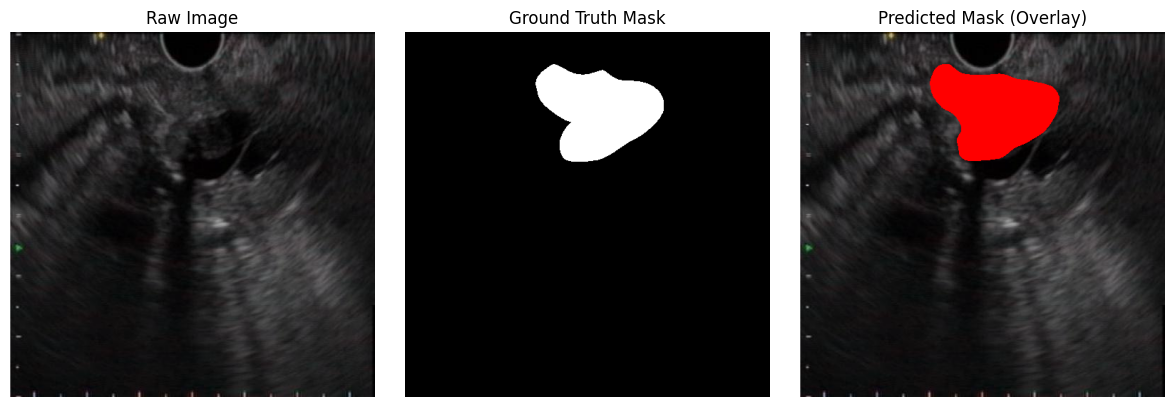

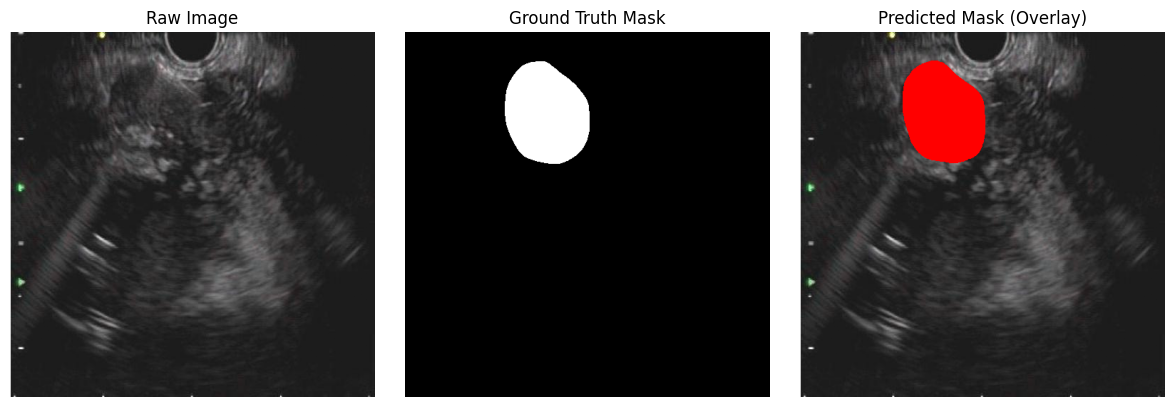

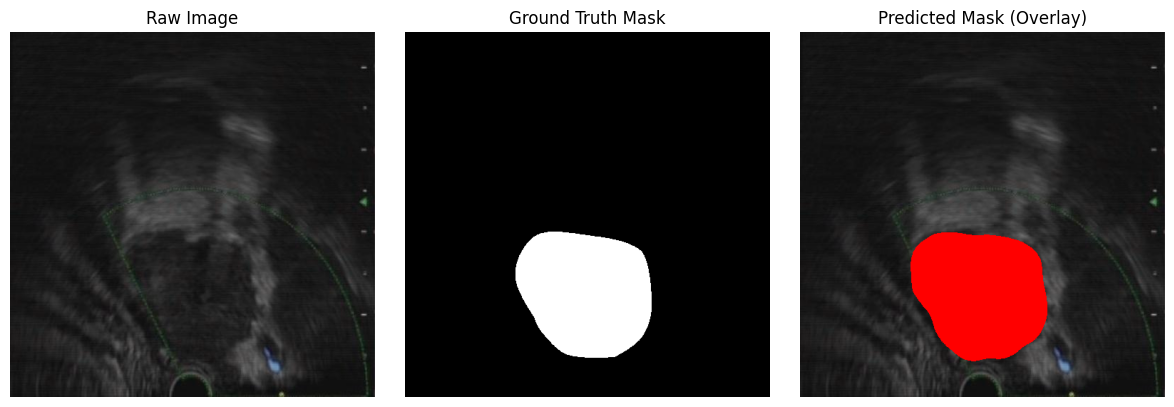

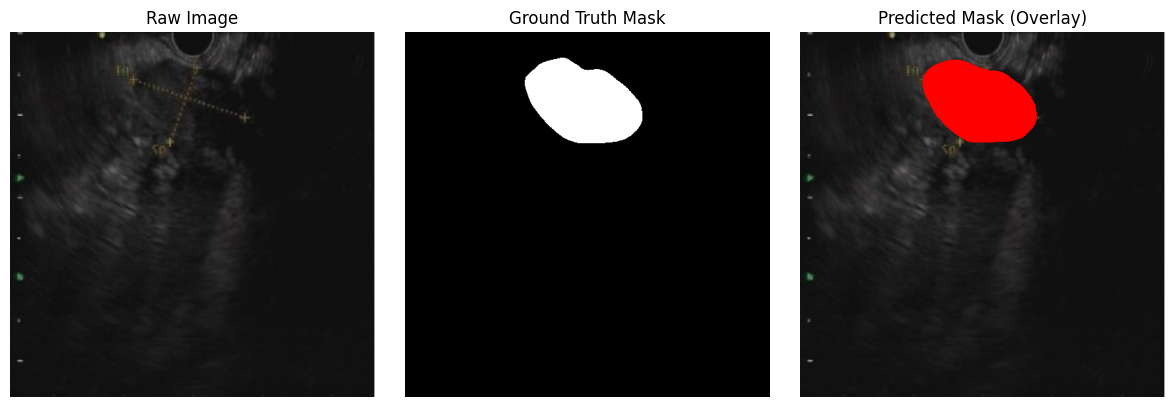

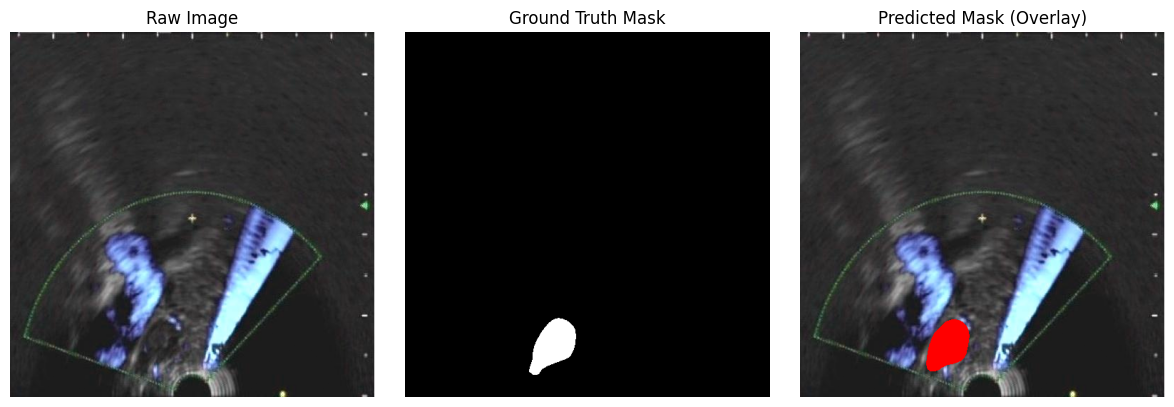

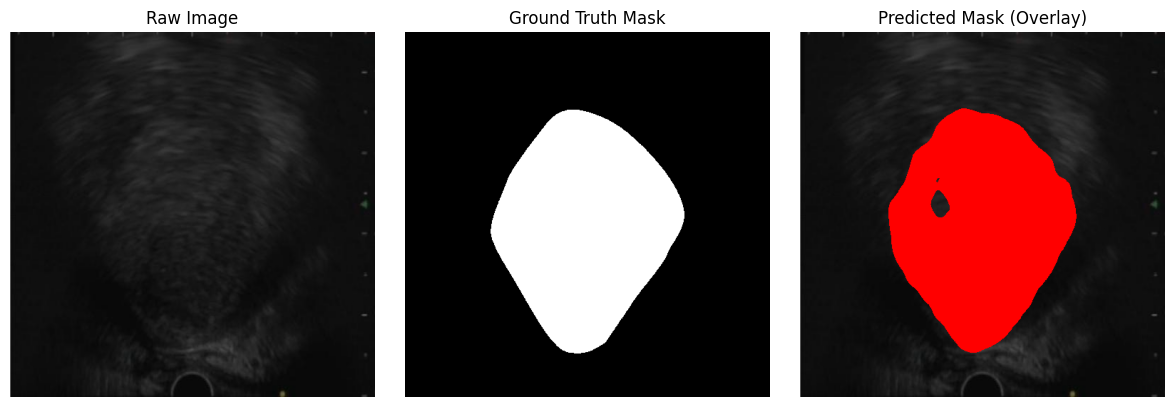

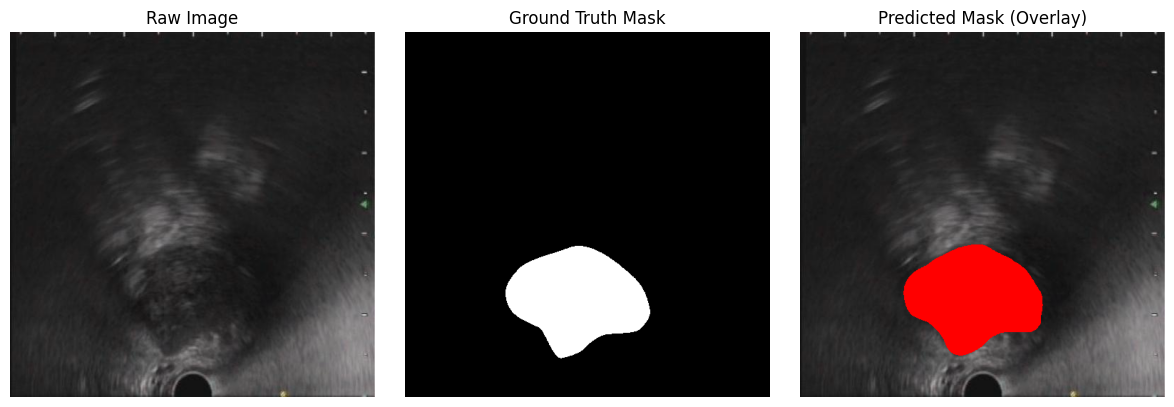

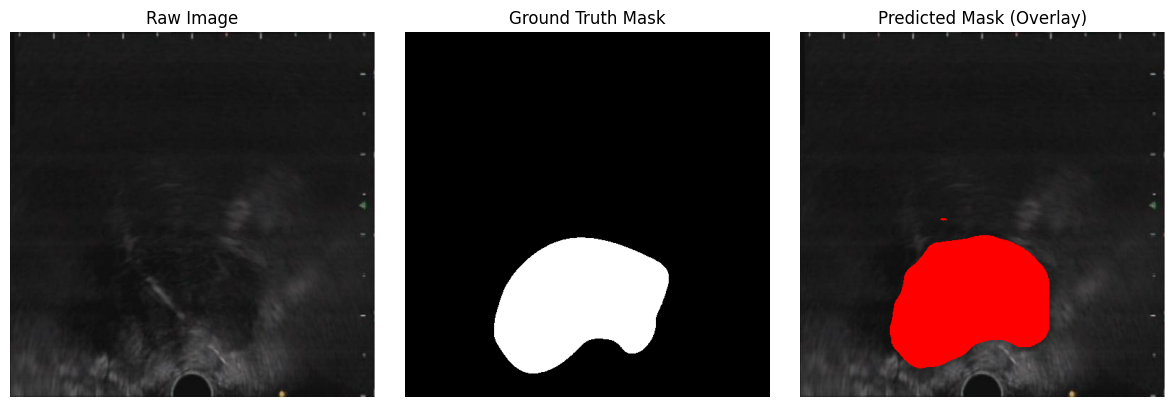

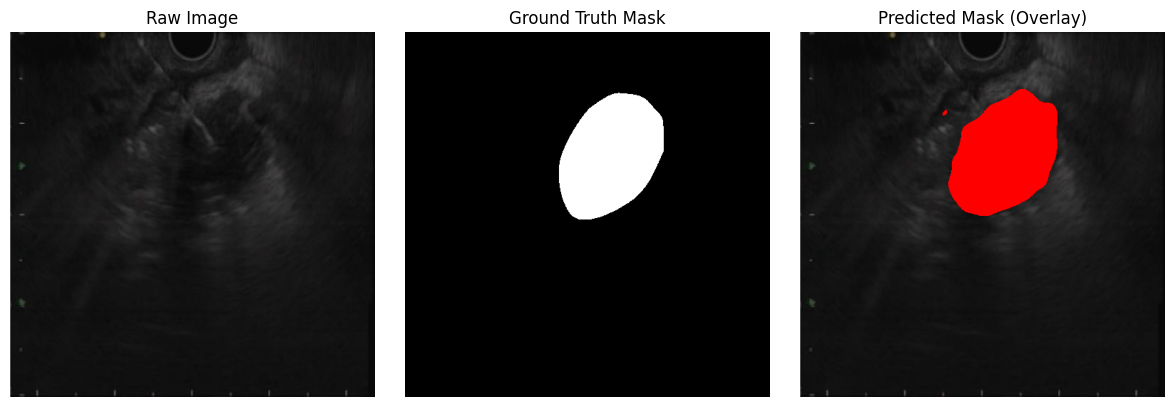

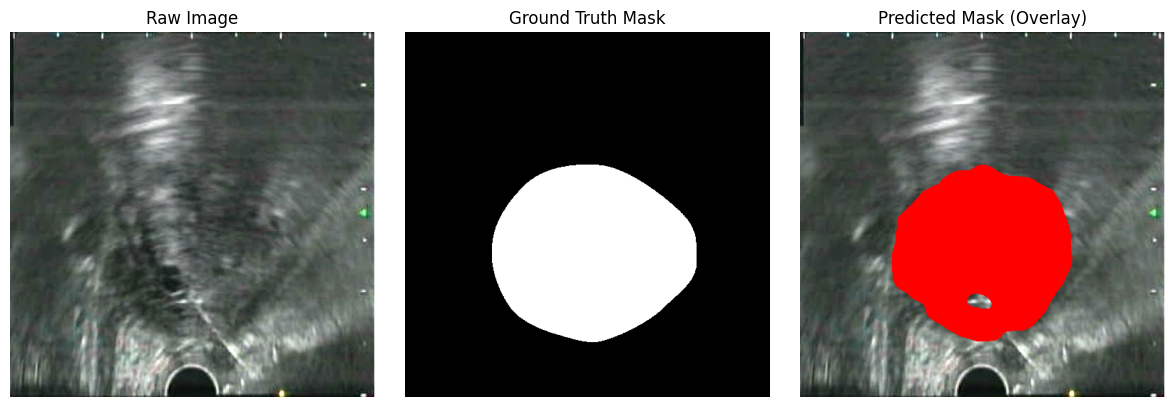

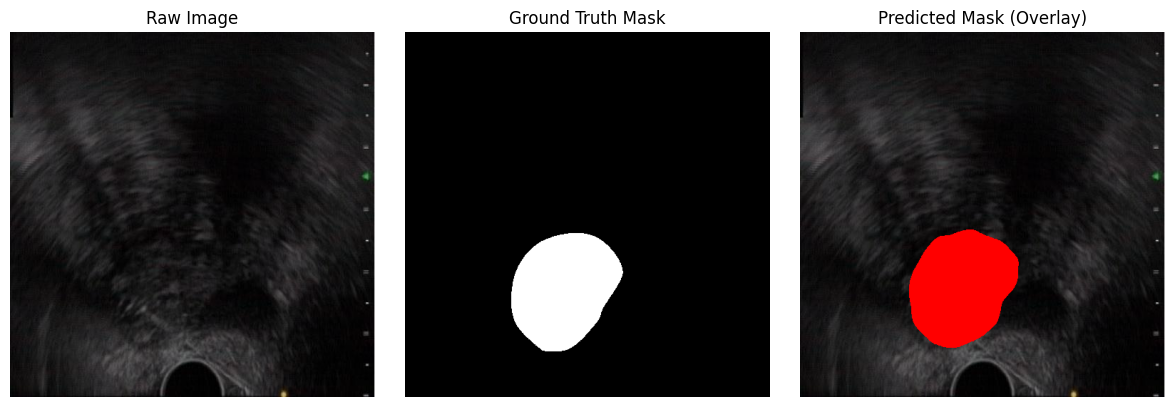

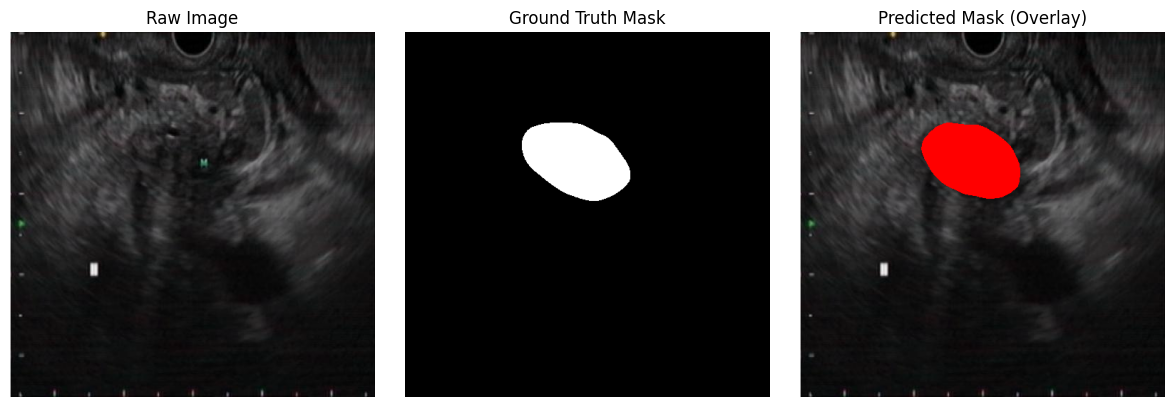

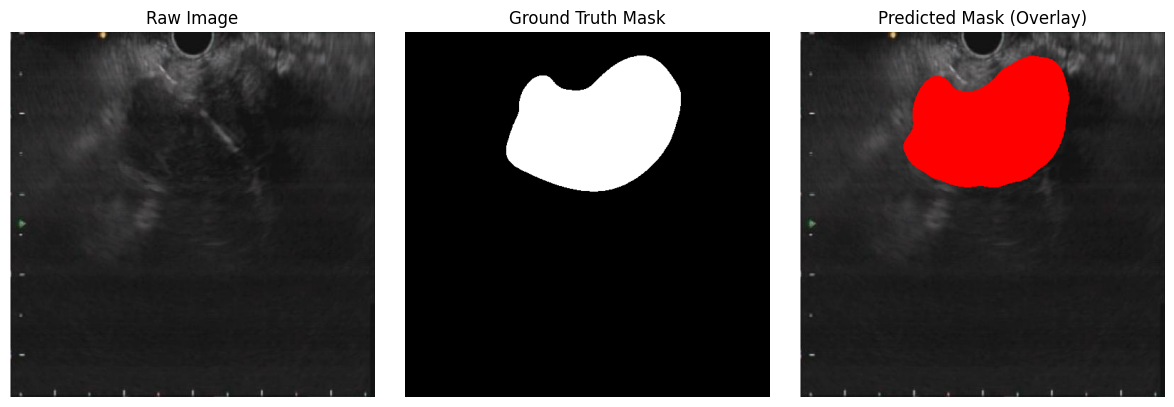

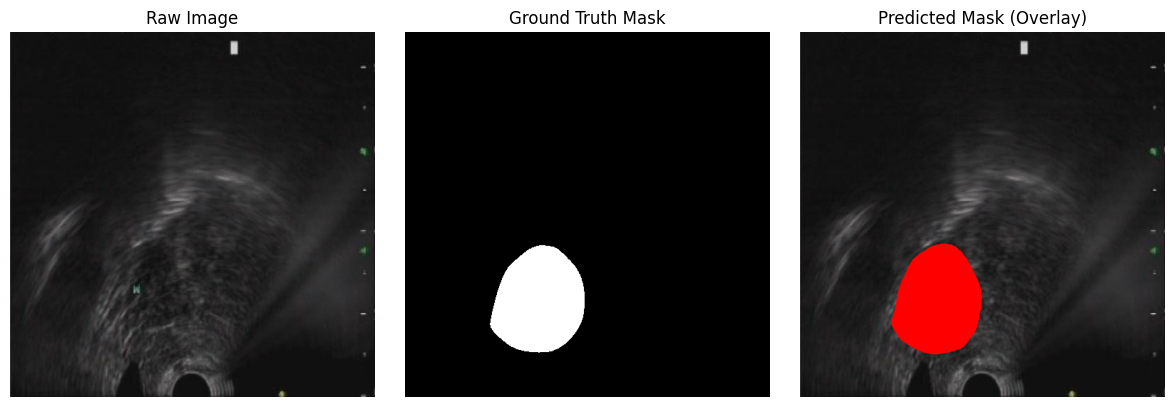

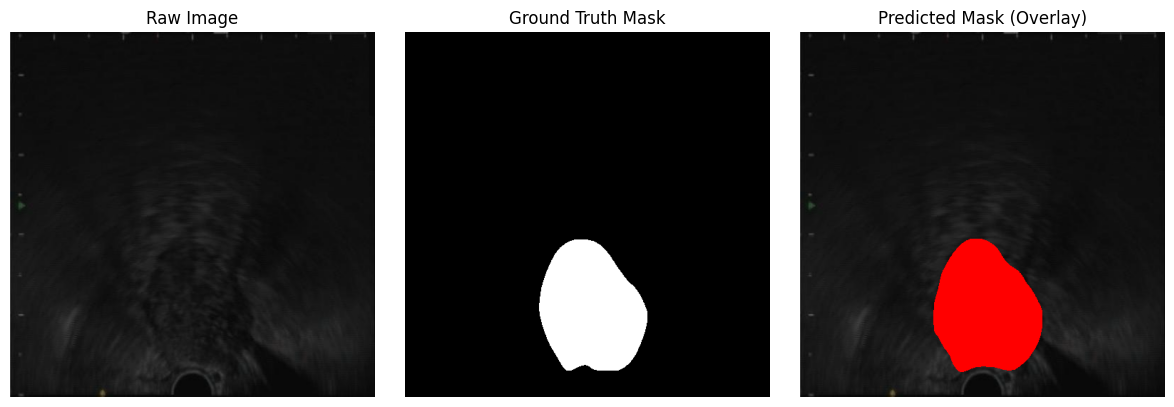

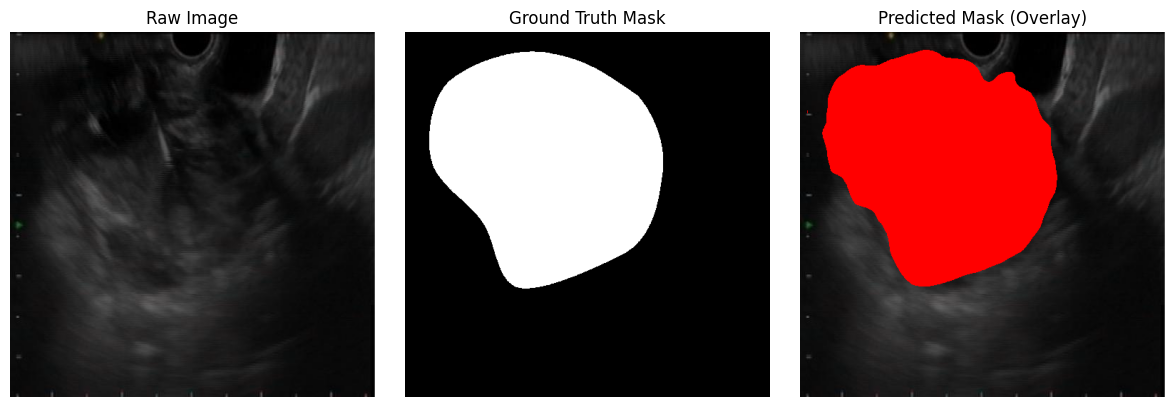

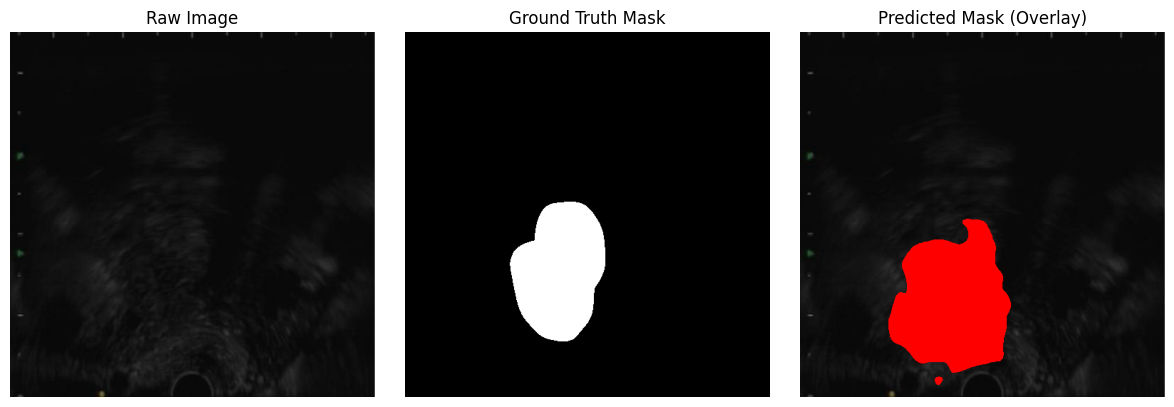

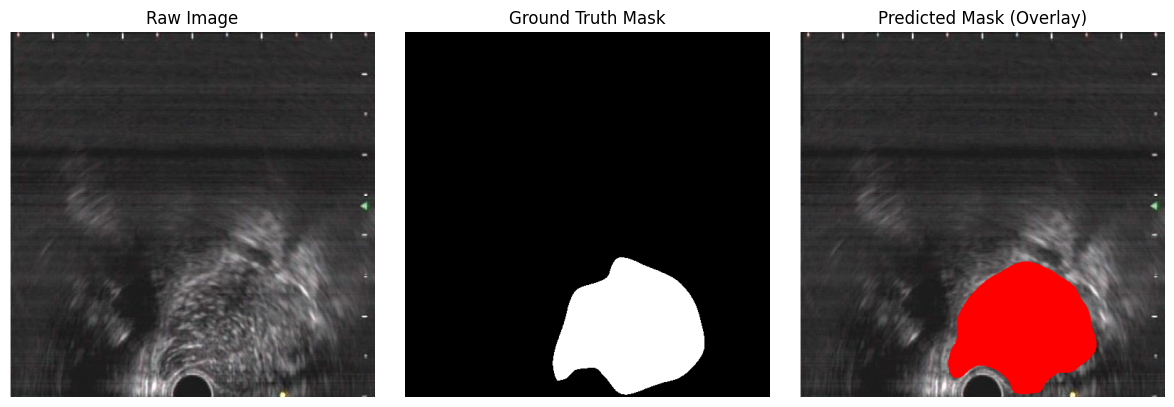

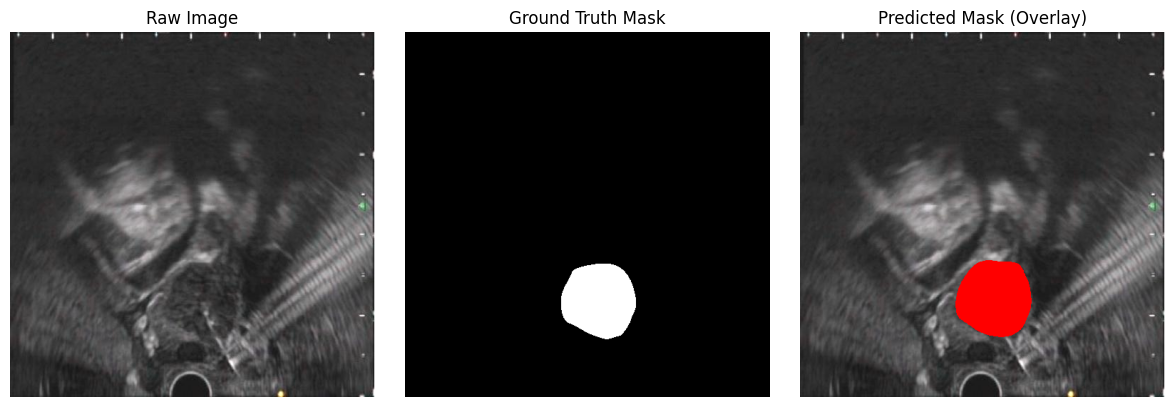

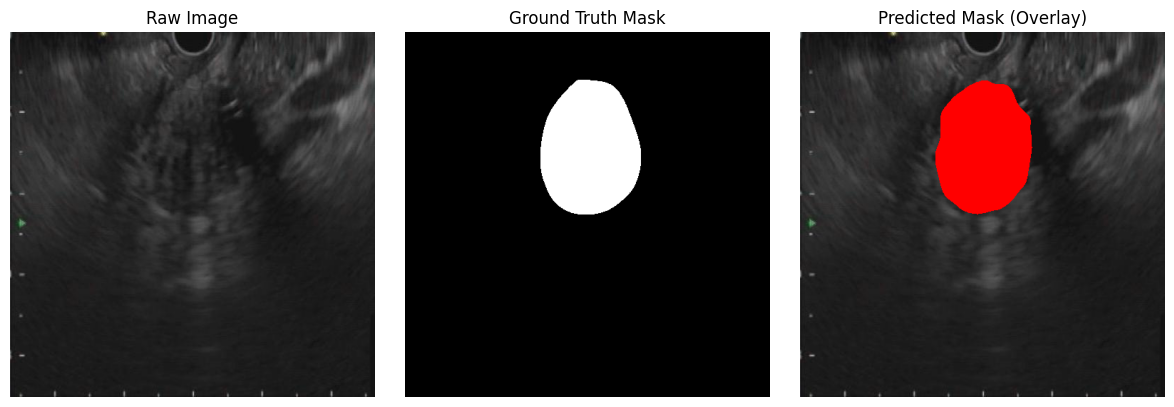

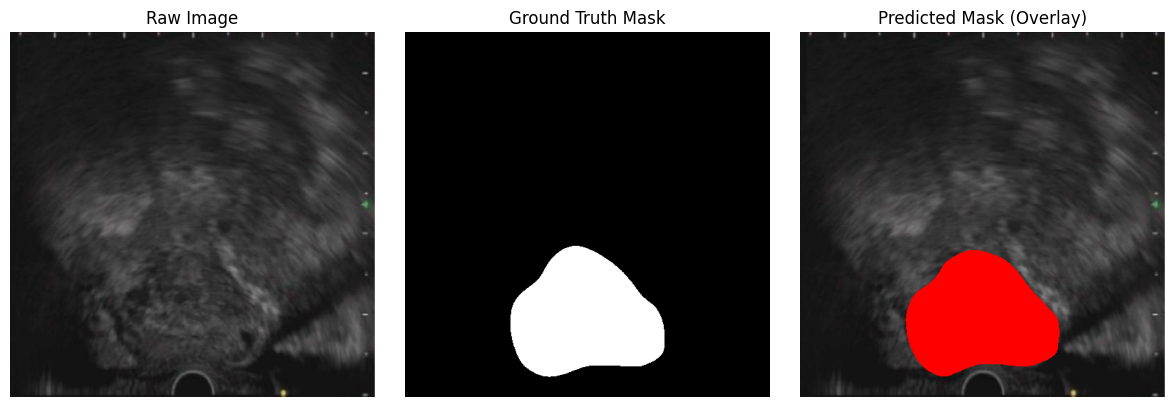

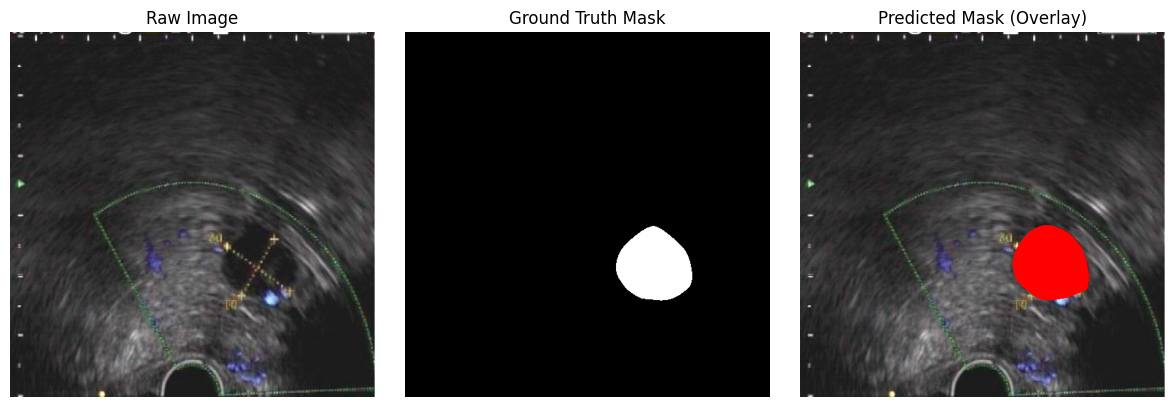

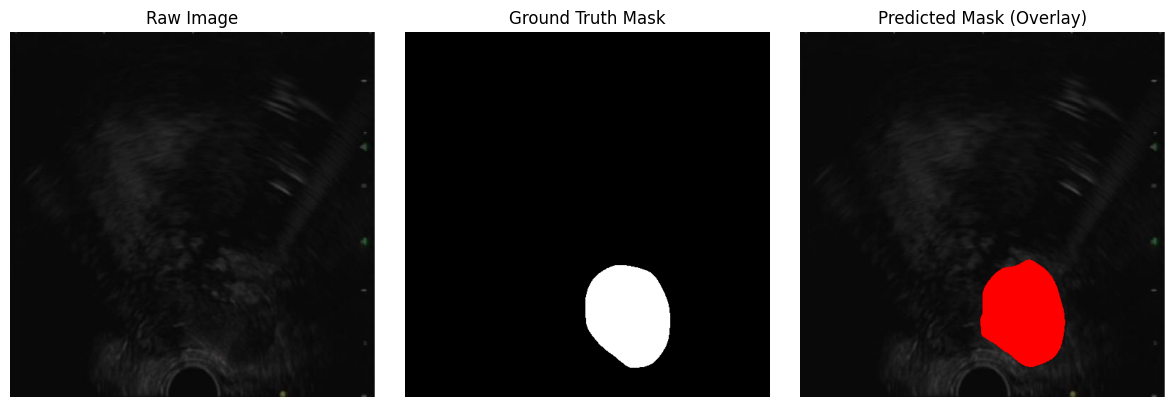

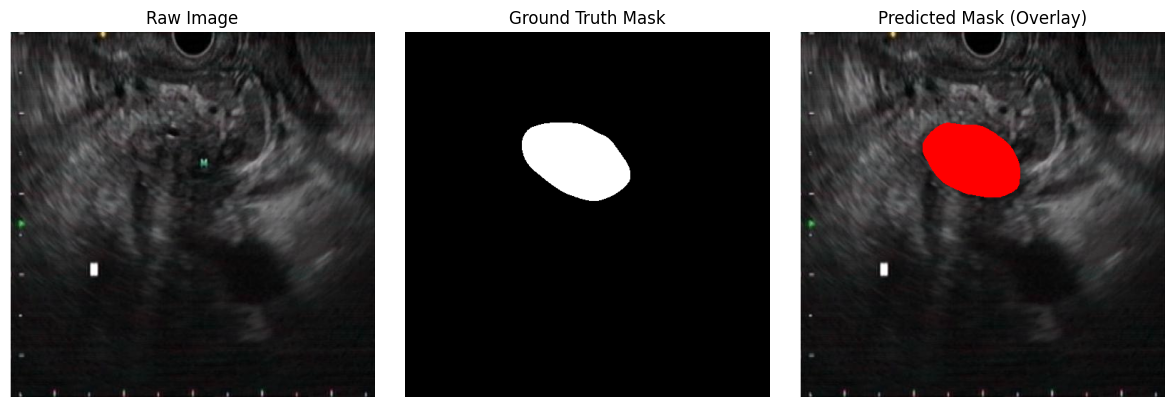

In [12]:
test_gen = TumorSegmentationGenerator(test_images, test_masks, batch_size=4)

visualize_predictions_triplet_colored(model, test_gen, num_images=50)

Melakukan evaluasi terhadap model yang telah dirancang untuk melihat tingkat keberhasilkan model dalam melakukan segmentasi

In [13]:
def evaluate_and_plot(model, test_gen):
    y_trues = []
    y_preds = []

    for i in range(len(test_gen)):
        x, y = test_gen[i]

        y_true = y[0]
        if y_true.ndim == 3:
            y_true = y_true[:, :, 0]

        output = model.predict(x, verbose=0)
        y_pred = output[0]
        if y_pred.ndim == 4:
            y_pred = y_pred[0, :, :, 0]
        elif y_pred.ndim == 3:
            y_pred = y_pred[:, :, 0]

        if y_pred.shape != y_true.shape:
            y_pred = tf.image.resize(y_pred[..., np.newaxis], y_true.shape, method='bilinear').numpy().squeeze()

        y_trues.extend(y_true.flatten())
        y_preds.extend(y_pred.flatten())

    y_trues = np.array(y_trues)
    y_preds = np.array(y_preds)
    y_preds_binary = (y_preds > 0.5).astype(np.uint8)

    # Metrics
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve,
        average_precision_score, jaccard_score
    )

    acc = accuracy_score(y_trues, y_preds_binary)
    prec = precision_score(y_trues, y_preds_binary, zero_division=0)
    rec = recall_score(y_trues, y_preds_binary, zero_division=0)
    f1 = f1_score(y_trues, y_preds_binary, zero_division=0)
    dice = 2 * (prec * rec) / (prec + rec + 1e-6)
    iou = jaccard_score(y_trues, y_preds_binary, zero_division=0)

    cm = confusion_matrix(y_trues, y_preds_binary)
    fpr, tpr, _ = roc_curve(y_trues, y_preds)
    auc_score = roc_auc_score(y_trues, y_preds)
    precision_vals, recall_vals, _ = precision_recall_curve(y_trues, y_preds)
    avg_prec = average_precision_score(y_trues, y_preds)

    # Plot
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    plt.subplot(1, 3, 2)
    plt.plot(fpr, tpr, color="orange", label=f"AUC = {auc_score:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(recall_vals, precision_vals, color="green", label=f"AP = {avg_prec:.2f}")
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"Dice     : {dice:.4f}")
    print(f"IoU      : {iou:.4f}")

In [14]:
evaluate_and_plot(model, test_gen)

<ipython-input-13-0cd6eae3c35a>:73: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


Accuracy : 0.9880
Precision: 0.9547
Recall   : 0.9325
F1 Score : 0.9435
Dice     : 0.9435
IoU      : 0.8930


Dapat terlihat bahwa model menghasilkan tingkat accuracy sebesar 98,3%, tingkat precision sebesar 93,6%, nilai recall sebesar 88%, nilai F1 score sebesar 90%, dengan dice coef sebesar 0.907, dan nilai IoU sebesar 0.831.

Dari nilai-nilai tersebut dapat disimpulkan bahwa model yang telah dirancang dapat melakukan segmentasi tumor pankreas dengan tepat dan menghasilkan prediksi yang cukup baik